In [ ]:
import torch
from nd_scaffold import GridModule

mod = GridModule(shape=(3,3,5), device='cuda:0', T=0.1)

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())

mod.shift(torch.tensor([1,0,0], device='cuda:0'))

print(mod.state)
print(mod.onehot())

mod.denoise_self()

print(mod.state)
print(mod.onehot())



In [24]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
import os


def test_mnist(num_imgs=1, prefix="", relu_theta=0.5, sparsity=0.1, N_h=400, T=0.01, plot_figs=False):
    import torchvision
    from torchvision import transforms

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float().to("cuda")[:num_imgs]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    shapes = [(3, 3, 5), (4, 4, 7)]
    velocities = torch.tile(torch.tensor([[1,1,1]]), (l, 1)).to("cuda")

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
            T=T
        )
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    if plot_figs:
        for i in range(1):
            original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
            noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
            recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
            print_imgs_side_by_side(
                original_img,
                noisy_img,
                recalled_img,
                out=f"{prefix}mnist_learned_{i}.png",
                captions=["original", "noisy", "recalled"],
                title="Learned",
            )

    similarity = torch.nn.functional.cosine_similarity(mnist_data, GS.recall(noisy_mnist))
    return similarity

test_mnist(11, sparsity=0.99, N_h=1000, prefix="", relu_theta=0.9)

module shapes:  [(3, 3, 5), (4, 4, 7)]
N_g     :  157
N_patts :  5040
N_h     :  1000
H: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0228],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0091],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0028],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0386],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0144],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0383]],
       device='cuda:0')
G: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G_: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9938, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9366, 1.0000], device='cuda:0')

module shapes:  [(3, 3, 5), (4, 4, 7)]
N_g     :  157
N_patts :  5040
N_h     :  200
H: tensor([[0.0000, 0.0000, 0.0154,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0120,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0073,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0058,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0287,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
G: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G_: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],

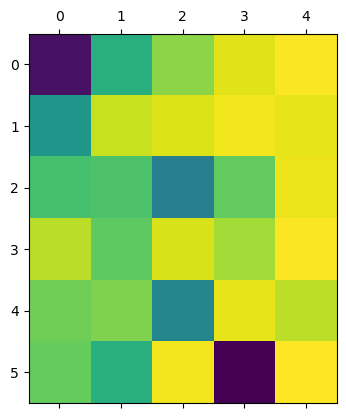

In [19]:
from matplotlib import pyplot as plt

temperatures = [0.001, 0.03, 0.01, 0.1, 0.3, 1]
N_h = [200, 400, 600, 800, 1000]

scores = np.zeros((len(temperatures), len(N_h)))

for i, T in enumerate(temperatures):
    for j, N in enumerate(N_h):
        scores[i, j] = test_mnist(11, sparsity=0.99, N_h=N, prefix=f"T_{T}_N_{N}_").mean().item()

print(scores)

fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap="viridis")

In [20]:
import pickle
with open("scores.pkl", "wb") as f:
    pickle.dump(scores, f)

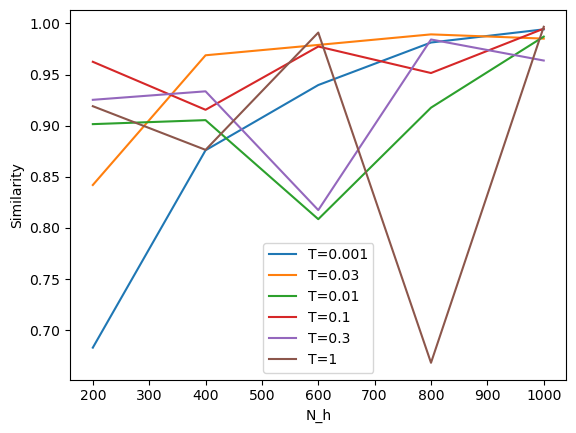

In [22]:
fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    ax.plot(N_h, scores[i], label=f"T={T}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()


78


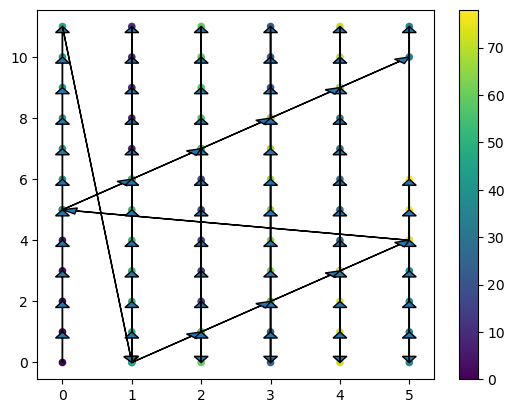

In [87]:
import torch


def spacefillingcurve(modules):
    number_of_module_dims = len(modules[0])
    assert all(len(module) == number_of_module_dims for module in modules)

    return addcurves(number_of_module_dims - 1, modules, [])


def addcurves(dim, modules, velocities):
    dims = len(modules[0])

    if dim == 0:
        a = 1
        for module in modules:
            a = a * module[dim]
        for i in range(a - 1):
            b = torch.zeros(dims)
            b[1] = 1
            velocities.append(b)
        b = torch.zeros(dims)
        b[dim] = 1
        b[dim + 1] = 1
        velocities.append(b)
        return velocities

    a = 1
    for module in modules:
        a = a * module[dim]
    for i in range(a-1):
        ## in spot so add curve(n-1, mods)
        addcurves(dim - 1, modules, velocities)
        ## add a vector of dimesnion n, all 0 but a 1 in the nth dimension
        b = torch.zeros(dims)
        b[dim] = 1
        b[1] = 1
        velocities.append(b)
    ## now add one last vector like a[n] + a[n+1]
    b = torch.zeros(dims)
    # open the torch array and set the nth and n+1th dimension to 1
    b[dim] = 1
    if dim != (dims - 1):
        b[dim + 1] = 1
    velocities.append(b)
    
    return velocities

modules = [(2,3), (3,4)]
v = spacefillingcurve(modules)

# graph walk

import matplotlib.pyplot as plt
import numpy as np

def plot_walk(v, modules):
    l1 = modules[0][0] * modules[1][0]
    l2 = modules[0][1] * modules[1][1]
    x = np.cumsum([0] + [i[0] for i in v]) % l1
    y = np.cumsum([0] + [i[1] for i in v]) % l2

    # plot arrows

    c = plt.scatter(x, y, c=range(len(x)), cmap='viridis', s=20)
    for i in range(len(x) - 1):
        plt.arrow(x[i], y[i], x[i + 1] - x[i], y[i + 1] - y[i], head_width=0.2, head_length=0.2, length_includes_head=True)
    plt.colorbar(c)

print(len(v))
plot_walk(v, modules)



In [ ]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]

scores = np.zeros((len(T), len(N_h)))

for i, t in enumerate(T):
    for j, dim in enumerate(N_h):
        scores[i, j] = test_mnist(100, sparsity=0.99, N_h=dim, prefix=f"T_{t}_N_{dim}_", plot_figs=False).mean().item()


module shapes:  [(3, 3, 5), (4, 4, 7)]
N_g     :  157
N_patts :  5040
N_h     :  500
H: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G_: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
G_[0]: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

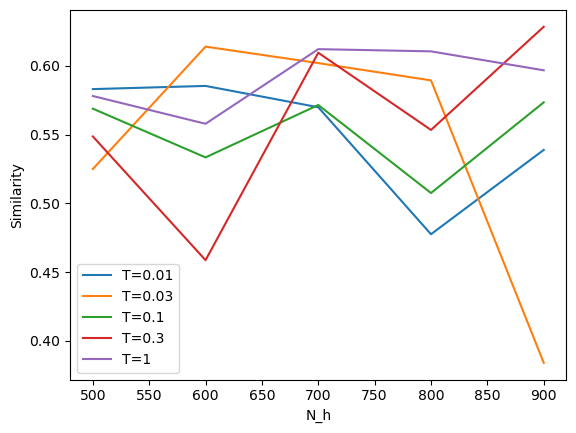

In [30]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]
fig, ax = plt.subplots()
for i, t in enumerate(T):
    ax.plot(N_h, scores[i], label=f"T={t}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()

